In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


# Leitura dos Dados de Classificação de Vinhos 

In [2]:
df_wine = pd.read_csv('../Data/dataset_vinhos.csv',sep=';')
wine_target_col = 'target'
wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,red


## Codificação 

In [3]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pd.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pd.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)
wine_feature_names = list(X.columns)

# Modelo de Classificação de Vinhos 

In [4]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Aula Modelos'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


2022/08/16 17:25:37 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/08/16 17:25:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

## Salvar Modelo

In [5]:
model_name = 'mlflow_modelo_salvo'

# Configuracao
criterion = 'gini'
max_depth = 5
SEED = 10
# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2, random_state=SEED)
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest
with mlflow.start_run(experiment_id=experiment_id, run_name = 'MLModelDeployment'):
    model_wine = tree.DecisionTreeClassifier(criterion=criterion, max_depth = max_depth, random_state=SEED)
    model_wine.fit(xtrain, ytrain)
    print("Decisn Tree Classifier (criterion=%s, max_depth=%f):" % (criterion, max_depth))
    mlflow.sklearn.save_model(model_wine, model_name)    

Decisn Tree Classifier (criterion=gini, max_depth=5.000000):


## Seleção de Variáveis Importantes 

Top Features
 ['alcohol' 'volatile acidity' 'free sulfur dioxide' 'residual sugar']


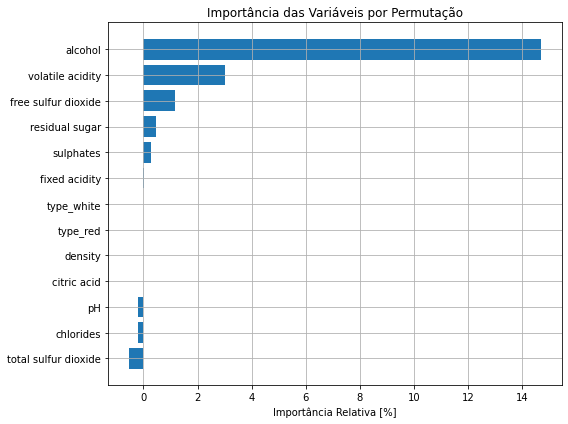

In [6]:
from sklearn.inspection import permutation_importance

ntop=4

plt.figure(figsize=(8,6))
r = permutation_importance(model_wine, xtest, ytest,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(wine_feature_names)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(wine_feature_names)[idx][::-1][:ntop]
print('Top Features\n',top_features)

# Modelo Com Assinatura e Exemplo de Entrada 

In [9]:
from mlflow.models.signature import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

model_name = 'mlflow_modelo_assinatura_com_exemplo'
Y = df_wine[wine_target_col]
X = df_wine[top_features]

nexamples = 4

# Configuracao
criterion = 'gini'
max_depth = 5
# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest
with mlflow.start_run(experiment_id=experiment_id, run_name = 'MLModelDeployment'):
    # mlflow.sklearn.autolog() # Precisa ser chamado antes do codigo do treinamento
    model_wine = tree.DecisionTreeClassifier(criterion=criterion, max_depth = max_depth)
    model_wine.fit(xtrain, ytrain)
    print("Decisn Tree Classifier (criterion=%s, max_depth=%f):" % (criterion, max_depth))
    mlflow.sklearn.save_model(model_wine, model_name)
    
    # Assinatura do Modelo Inferida pelo MLFlow
    inf_signature = infer_signature(xtrain, model_wine.predict(xtrain))
    # Assinatura Manual, forçando tipos e descricoes.
    input_schema = Schema([
        ColSpec("double", "alcohol"),
        ColSpec("double", "volatile acidity"),
        ColSpec("double", "sulphates"),
        ColSpec("double", "residual sugar"),
    ])
    output_schema = Schema([
        ColSpec("integer", "classe predita")
    ])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)
    # Print das assinaturas
    print('=== Assinatura Sugerida')
    print(inf_signature)
    print('=== Assinatura Explícita')
    print(signature)
    
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in top_features}
#     input_example = {
#         'alcohol': xtrain['alcohol'].values[:2],
#         'volatile acidity':  xtrain['volatile acidity'].values[:2],
#         'sulphates':  xtrain['sulphates'].values[:2],
#         'residual sugar':  xtrain['residual sugar'].values[:2],
#     }
    # Adicionar o exemplo como parametro do log
    mlflow.sklearn.log_model(model_wine,
                             model_name,
                             signature = inf_signature,
                             input_example = input_example)


Decisn Tree Classifier (criterion=gini, max_depth=5.000000):


MlflowException: Path 'mlflow_modelo_assinatura_com_exemplo' already exists and is not empty

In [9]:
# mlflow.end_run()
#!mlflow ui
# Para usar o sqlite como repositorio
# mlflow ui --backend-store-uri sqlite:///mlflow.db

# Registro de Modelos

Treinamento e deployment de um modelo de classificador de vinhos tintos.

    1 - Filtragem dos dados de vinho branco e separação da base de operação
    2 - Treinamento de modelos padrão com o PyCaret (árvore, logística e SVM)
    3 - Registro do modelo e validaçãp para staging caso precisão mínima de 70%
    4 - Servir o modelo em staging para testes
    5 - Consumir o modelo por biblioteca requests com a base de operação
    6 - Consumir a base operação como uma aplicação python

## 1 - Filtrar Vinhos Tintos 

In [11]:
data_wine = df_wine[df_wine.type_red == 1].drop(['type_red', 'type_white'], axis=1)     
# Separar parte para compor a base de operacao
data_wine, data_operation, ytrain, ytest = model_selection.train_test_split(data_wine, 
                                                                        data_wine[wine_target_col],
                                                                        test_size=0.1)
data_wine[wine_target_col]      = ytrain
data_operation[wine_target_col] = ytest

# Base de vinhos brancos
data_white_wine = df_wine[df_wine.type_red == 0].drop(['type_red', 'type_white'], axis=1)

## 2 - Treinar Modelos com PyCaret 

In [12]:
import pycaret.classification as pc
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'classificador_vinho'

# train/test
s = pc.setup(data = data_wine, 
             target = wine_target_col,
             train_size=0.7,
             silent = True,
             feature_selection = True,
             feature_selection_threshold = 0.6,
             feature_selection_method = 'classic',
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True)
models = ['lr', 'dt', 'rbfsvm']
bestmodel = pc.compare_models(include = models, sort='precision')
# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 'threshold',
                         'learning','vc','feature',
                       ]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True, use_train_data=False)
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue

INFO:logs:Saving 'Feature Importance.png'
INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


## 3 - Registrar e Validar o Modelo Melhor Precisão

In [12]:
from mlflow.tracking import MlflowClient
mlflow.set_registry_uri("sqlite:///mlruns.db")

registered_model_name = 'modelo_vinho_tinto'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4


# Test set
pred_holdout = pc.predict_model(bestmodel)
pr = metrics.precision_score(pred_holdout[wine_target_col], pred_holdout['Label'])
if pr > min_precision:
    print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
    # Pycaret exporta junto o pipeline de preprocessamento
    pc.save_model(bestmodel, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(data_wine.drop(wine_target_col, axis=1).columns)
    inf_signature = infer_signature(data_wine[model_features], model_pipe.predict(data_wine))
    # Exemplo de entrada para o MLmodel
    input_example = {x: data_wine[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.transition_model_version_stage(
        name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        stage="Staging"
    )

else:
    print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')




INFO  [logs] Initializing predict_model()
INFO  [logs] predict_model(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2854, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO  [logs] Checking exceptions
INFO  [logs] Preloading libraries
INFO  [logs] Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7330,0.8228,0.6974,0.7771,0.7351,0.4675,0.4703


INFO  [logs] Initializing save_model()
INFO  [logs] save_model(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2854, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), model_name=./modelo_vinho_tinto, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='target',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
              

=> Aceito o modelo com precisão 0.7771428571428571 (min: 0.7)
Transformation Pipeline and Model Successfully Saved


INFO  [logs] Initializing load_model()
INFO  [logs] load_model(model_name=./modelo_vinho_tinto, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


Successfully registered model 'modelo_vinho_tinto'.
2022/03/25 19:22:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_vinho_tinto, version 1
Created version '1' of model 'modelo_vinho_tinto'.


## 4 - Servir o Modelo com o MLFlow 

In [20]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'

!mlflow models serve -m "models:/modelo_vinho_tinto/Staging" --no-conda -p 5001

# !curl http://localhost:5001/invocations -X POST -H "Content-Type:application/json; format=pandas-split" --data "{\"columns\":[\"alcohol\", \"chlorides\", \"citric acid\", \"density\", \"fixed acidity\", \"free sulfur dioxide\", \"pH\", \"residual sugar\", \"sulphates\", \"total sulfur dioxide\", \"volatile acidity\"],\"data\":[[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4], [11.8, 0.26, 0.52, 1.8, 0.071, 6.0, 10.0, 0.9968, 3.2, 0.72, 10.2]]}"

In [1]:
!mlflow server --backend-store-uri sqlite:///mlruns.db --default-artifact-root file:./mlserver/

## 6 - Consumir o Modelo com Exemplos 

### 6.1 - Dados Vinhos Tintos Operacao 

In [21]:
import requests
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

http_data = data_operation.drop(wine_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(data_operation[wine_target_col], data_operation['operation_label']))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        75
           1       0.71      0.69      0.70        61

    accuracy                           0.74       136
   macro avg       0.73      0.73      0.73       136
weighted avg       0.73      0.74      0.73       136



### 6.2 - Dados Vinhos Brancos 

In [22]:
import requests
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

http_data = data_white_wine.drop(wine_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)


data_white_wine.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(data_white_wine[wine_target_col], data_white_wine['operation_label']))

              precision    recall  f1-score   support

           0       0.50      0.80      0.61      1348
           1       0.85      0.58      0.69      2613

    accuracy                           0.66      3961
   macro avg       0.67      0.69      0.65      3961
weighted avg       0.73      0.66      0.66      3961



## 7 - Utilizar Como uma Biblioteca da Aplicacao  

In [23]:
# mlflow.get_registry_uri()

model_uri = f"models:/modelo_vinho_tinto/Staging"
loaded_model = mlflow.sklearn.load_model(model_uri)


http_data = data_operation.drop(wine_target_col,axis=1)
data_operation.loc[:, 'operation_label'] = loaded_model.predict(http_data)

print(metrics.classification_report(data_operation[wine_target_col], data_operation['operation_label']))


              precision    recall  f1-score   support

           0       0.75      0.77      0.76        75
           1       0.71      0.69      0.70        61

    accuracy                           0.74       136
   macro avg       0.73      0.73      0.73       136
weighted avg       0.73      0.74      0.73       136



In [19]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='target',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                                                    top_features_to_pick=0.4)),
                ('fix_multi', 'passthrough'), ('dfs', 'passthrough'),
                ('pca', 'passthrough'),
                ['trained_model',
                 LogisticRegression(C=1.0, class_weight=None, d